In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
import xlsxwriter
import scipy.stats as stats
import os,sys
import pickle
import random
import math
import time
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from collections import OrderedDict
import pandas as pd
import shapefile as shp
import geopandas as gpd
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from get_population_by_state import GetAgeSex
import seaborn as sns

In [3]:
measurement_types = ['no2', 'pm2.5', 'pm10']
data = []
for measurement_type in measurement_types:
    for ac_type in ['AC', 'AC_5', 'AC_95']:
        fname = "output_files/results_{}_{}_pvalue.csv".format(measurement_type, ac_type)
        df = pd.read_csv(fname)
        a1 = df.loc[df['term'] == 'ev_sales', 'estimate'].item()
        a2 = df.loc[df['term'] == 'nonev_sales', 'estimate'].item()
        data.append({
            "measurement_type": measurement_type,
            "ac_type": ac_type,
            "ev_sales": 1/a1,
            "nonev_sales": 1/a2
        })
    
mdf = pd.DataFrame(columns=['measurement_type', 'ac_type', 'ev_sales', 'nonev_sales'], data=data)


In [3]:
mdf

,measurement_type,ac_type,ev_sales,nonev_sales
0,no2,AC,-13.856530,322.366060
1,no2,AC_5,-28.864852,740.293140
2,no2,AC_95,-11.078155,243.054744
3,pm2.5,AC,-24.392909,251.675992
4,pm2.5,AC_5,-63.722589,686.918420
5,pm2.5,AC_95,-16.693408,165.252581
6,pm10,AC,-6.569024,141.700065
7,pm10,AC_5,-12.911143,302.009611
8,pm10,AC_95,-5.071925,102.543998


In [46]:
import statistics
from math import sqrt


def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25, label=None, point_color='r',
                            alpha=0.7):
    mean = values[0]

    left = x - horizontal_line_width / 2
    top = max(values)
    right = x + horizontal_line_width / 2
    bottom = min(values)
    plt.plot([x, x], [top, bottom], color=color, alpha=alpha)
    plt.plot([left, right], [top, top], color=color, alpha=alpha)
    plt.plot([left, right], [bottom, bottom], color=color, alpha=alpha)
    plt.plot(x-0.0055, mean, 'o', color=point_color, label=label)

    return mean

def plot_confidence_interval_v2(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25, label=None, point_color='r',
                            alpha=0.7):
    autom = values
    ev = None
    if len(autom) == 2:
        nonev, ev = autom[0][0], autom[1][0]
    else:
        nonev = autom[0][0]

    left = x - horizontal_line_width / 2
    top = max(values)
    right = x + horizontal_line_width / 2
    bottom = min(values)
    print(x, ev)

    if ev:
        plt.bar(x, nonev-np.abs(ev), color=color, alpha=alpha)
        plt.bar(x, np.abs(ev), bottom=nonev-np.abs(ev), color=point_color, alpha=alpha, label=label)
    else:
        plt.bar(x, nonev, color=color, alpha=alpha, label=label)


    ax = plt.gca()
#     ax.annotate("hello", xy=(0.5, 300), xycoords='data',
#                 xytext=(1.5, 1.5), textcoords='offset points')
#     plt.text(0.5, 330, "{} ({}-{})", fontsize=8, ha="center")
#     ax.text(330, 1, "c)", transform=ax.transAxes, size=12, color='black')

#     ax.arrow(x,0,50,0,color=color,length_includes_head=True,lw=0,head_width=0, 
#     head_length=0, width=0.3, fc=color,ec=color)
#     ax.annotate(txt, xy=(i, y-dy/6),fontsize=18,horizontalalignment='center',verticalalignment= 'center')
#     plt.xlim(-320, 30)

    return autom

In [47]:
plt.text?

1 -13.856529592990986
-3 None
2 -24.392909128035058
-2 None
3 -6.569023785506217
-1 None


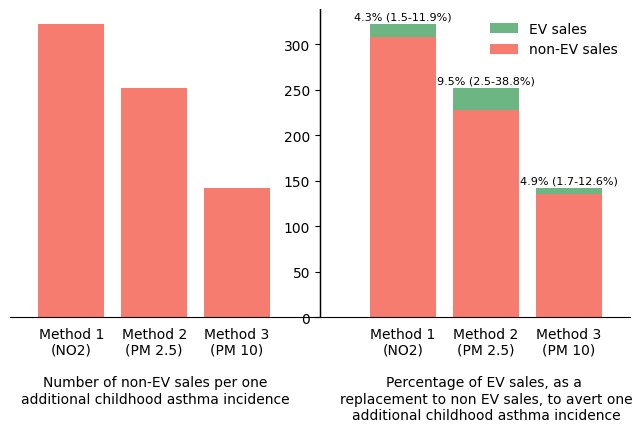

In [55]:
def call_for_ax(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # hide one of the zero labels and adjust the other
    ax.yaxis.get_major_ticks()[3].label1.set_visible(False)
    ax.xaxis.get_major_ticks()[3].label1.set_horizontalalignment("right")

    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 0, "<k", transform=ax.get_yaxis_transform(), clip_on=False)
    return ax


from mpl_toolkits.axisartist.axislines import AxesZero

sns.reset_defaults()

plt.close()
plt.subplots(figsize=(8,4))
ev_cmap = plt.get_cmap("Greens")
nonev_cmap = plt.get_cmap("Reds")
annot = ["4.3% (1.5-11.9%)", "9.5% (2.5-38.8%)", "4.9% (1.7-12.6%)"]
for index, measurement_type in enumerate(measurement_types):
    x1 = index
    x2 = index-4
    y1 = mdf[mdf['measurement_type'] == measurement_type]['ev_sales'].tolist()
    y2 = mdf[mdf['measurement_type'] == measurement_type]['nonev_sales'].tolist()
    label1 = "EV sales" if index == 0 else None
    label2 = "non-EV sales" if index == 0 else None

    plot_confidence_interval_v2(x1+1, [y2, y1], color=nonev_cmap(0.6), label=label1, point_color=ev_cmap(0.7))
    plot_confidence_interval_v2(x2+1, [y2], color=nonev_cmap(0.6), label=label2, point_color=nonev_cmap(0.7))
#     print(x1,y2,annot[index])
    plt.text(x1+1, y2[0]+5, annot[index], fontsize=8, ha="center")


ax = plt.gca()

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.axvline(linewidth=1, color='k')

ax.xaxis.set_ticks_position('none') 
legend_one = "\n\n\nNumber of non-EV sales per one\nadditional childhood asthma incidence"
legend_two = "\n\n\nProjected percentage of EV sales, as a \nreplacement to non EV sales, to avert one\nadditional childhood asthma incidence"

plt.xticks([-3, -2, -1.99, -1, 0, 1, 2, 2.01, 3], ["Method 1\n(NO2)", "Method 2\n(PM 2.5)", legend_one,
                                             "Method 3\n(PM 10)"," " , "Method 1\n(NO2)", "Method 2\n(PM 2.5)", legend_two,
                                                   "Method 3\n(PM 10)"])
# plt.xticks([-150, 0, 55], [legend_one, "", legend_two])
plt.legend(loc='upper right', frameon=False)
plt.savefig("output_images/final_figure_v4.png", bbox_inches='tight')
plt.show()

In [37]:
measurement_types = ['no2', 'pm2.5', 'pm10']
data = []
for measurement_type in measurement_types:
    for ac_type in ['AC', 'AC_5', 'AC_95']:
        fname = "output_files/results_{}_{}_pvalue.csv".format(measurement_type, ac_type)
        df = pd.read_csv(fname)
        a1 = df.loc[df['term'] == 'ev_sales', 'estimate'].item()
        s1 = df.loc[df['term'] == 'ev_sales', 'std.error'].item()
        p1 = df.loc[df['term'] == 'ev_sales', 'p.value'].item()
        
        a2 = df.loc[df['term'] == 'nonev_sales', 'estimate'].item()
        s2 = df.loc[df['term'] == 'nonev_sales', 'std.error'].item()
        p2 = df.loc[df['term'] == 'nonev_sales', 'p.value'].item()

        data.append({
            "measurement_type": measurement_type,
            "ac_type": ac_type,
            "ev_sales": a1,
            "nonev_sales": a2,
            "s1": s1,
            "s2": s2,
            "p1": p1,
            "p2": p2
        })


In [677]:
import math
round(5.55)

6

In [678]:
def th(x):
    return "{:.2}".format(x)

def ee(x):
    return round(1/x)

wrapper = {}
for d in data:
    proxy = d.get("measurement_type")
    if proxy not in wrapper:
        wrapper[proxy] = {}
    if 'evintercept' not in wrapper[proxy] and d.get('ac_type') == 'AC':
        wrapper[proxy]['evintercept'] = ee(d.get("ev_sales"))
        wrapper[proxy]['nonevintercept'] = ee(d.get("nonev_sales"))
    if 'evstd' not in wrapper[proxy] and d.get('ac_type') == 'AC':
        wrapper[proxy]['evstd'] = th(d.get("s1"))
        wrapper[proxy]['nonstd'] = th(d.get("s2"))
    if 'evpvalue' not in wrapper[proxy] and d.get('ac_type') == 'AC':
        wrapper[proxy]['evpvalue'] = th(d.get("p1"))
        wrapper[proxy]['nonpvalue'] = th(d.get("p2"))
    if d.get('ac_type') in ['AC_5', 'AC_95']:
        if 'evci' not in wrapper[proxy]:
            wrapper[proxy]['evci'] = []
            wrapper[proxy]['nonevci'] = []
        wrapper[proxy]['evci'].append(ee(d.get("ev_sales")))
        wrapper[proxy]['nonevci'].append(ee(d.get("nonev_sales")))


In [776]:
def get_pvalue_sign(x):
    x = float(x)
    if x<=0.01:
        return pvalue_lookup.get("0.01")
    elif x<=0.05:
         return pvalue_lookup.get("0.01")
    elif x<=0.1:
         return pvalue_lookup.get("0.1")
    else:
        return ""
        
        
def cal_rep_rate(nonev, ev):
    return "{:.1f}".format(((np.abs(ev))/nonev)*100)

pvalue_lookup = {
    "0.01": "***", 
    "0.05": "**",
    "0.1": "*" 
}
index = 1
row=[]
for mtype, d in wrapper.items():
    ev_p_sign = get_pvalue_sign(d.get("evpvalue"))
    nonev_p_sign = get_pvalue_sign(d.get("nonpvalue"))
    ev_sale_value = "{} ({} - {}){}".format(d.get("evintercept"), d.get("evci")[0], d.get("evci")[1], ev_p_sign)
    nonev_sale_value = "{} ({} - {}){}".format(d.get("nonevintercept"), d.get("nonevci")[1], d.get("nonevci")[0], nonev_p_sign)
    rep_rate = cal_rep_rate(d.get("nonevintercept"), d.get("evintercept"))
    rep_rate_5 = cal_rep_rate(d.get("nonevci")[1], d.get("evci")[0])
    rep_rate_95 = cal_rep_rate(d.get("nonevci")[0], d.get("evci")[1])
    replacement_rate = "{}% ({}-{}%)".format(rep_rate, rep_rate_5, rep_rate_95)
    row.append(["Method {}".format(index), mtype.upper(), ev_sale_value, nonev_sale_value, replacement_rate]) 
    
    index+=1
row.append(["***, **, and * shows the significance at 10%, 5%, and 1%."])
national_inc = ["7"]
columns = ["Method", "Proxy to TRAP", "EV sales",  "non-EV sales", "Replacement rate"]
mdf = pd.DataFrame(columns=columns, data=row)

In [777]:
mdf.to_csv("output_files/Table_1_v2.csv", index=False)

In [778]:
mdf

,Method,Proxy to TRAP,EV sales,non-EV sales,Replacement rate
0,Method 1,NO2,-14 (-29 - -11)***,322 (243 - 740)***,4.3% (11.9-1.5%)
1,Method 2,PM2.5,-24 (-64 - -17),252 (165 - 687)***,9.5% (38.8-2.5%)
2,Method 3,PM10,-7 (-13 - -5)***,142 (103 - 302)***,4.9% (12.6-1.7%)
3,"***, **, and * shows the significance at 10%, ...",None,None,None,None


In [755]:
np.abs(-5.5)

5.5

In [670]:
#     row.append([index, mtype, "intercept", d.get("evintercept"), d.get("nonevintercept")])
#     row.append( [index, mtype, "interval", "({}, {})".format() ,  "({}, {})".format(*d.get("nonevci"))])
#     row.append([index, mtype, "std error", d.get("evstd"), d.get("nonstd")])
#     row.append([index, mtype, "p value", d.get("evpvalue"), d.get("nonpvalue")])

{'no2': {'evintercept': -14,
  'nonevintercept': 322,
  'evstd': '0.035',
  'nonstd': '0.00038',
  'evpvalue': '0.042',
  'nonpvalue': '8.7e-15',
  'evci': [-24, -16],
  'nonevci': [188, 77]},
 'pm2.5': {'evintercept': -24,
  'nonevintercept': 252,
  'evstd': '0.041',
  'nonstd': '0.00042',
  'evpvalue': '0.32',
  'nonpvalue': '1.2e-18',
  'evci': [149, 24],
  'nonevci': [227, 69]},
 'pm10': {'evintercept': -7,
  'nonevintercept': 142,
  'evstd': '0.075',
  'nonstd': '0.00064',
  'evpvalue': '0.042',
  'nonpvalue': '2.1e-23',
  'evci': [-60, 43],
  'nonevci': [150, 61]}}

In [388]:
tdf = pd.read_csv("output_files/model_AC_2013_2019_no2.csv")
col = 'AC'

In [158]:
tdf

,State,FCEV Sales,FCEV Market Share,BEV Sales,BEV Market Share,PHEV Sales,PHEV Market Share,year,State Name,state_code,...,incidence_cases,AC,AC_5,AC_95,IR,SAF,SAF_5,SAF_95,nonev_market_share,year_fixed
0,Alabama,0,0.0,77,0.0004,99,0.0005,2013,Alabama,1,...,8230.162553,869.224824,367.615729,1174.248160,0.008370,0.105615,0.044667,0.142676,0.999111,3
1,Arizona,0,0.0,705,0.0023,544,0.0017,2013,Arizona,4,...,12078.640683,3642.148404,1672.224665,4679.067603,0.008370,0.301536,0.138445,0.387384,0.996097,3
2,Arkansas,0,0.0,24,0.0002,74,0.0006,2013,Arkansas,5,...,5385.399750,583.547422,246.000274,789.801812,0.008370,0.108357,0.045679,0.146656,0.999205,3
3,Colorado,0,0.0,799,0.0035,635,0.0028,2013,Colorado,8,...,9422.353012,2015.605004,893.202094,2646.798878,0.008370,0.213917,0.094796,0.280906,0.993718,3
4,Connecticut,0,0.0,400,0.0025,718,0.0044,2013,Connecticut,9,...,2584.233496,535.250544,234.000903,708.134438,0.003661,0.207122,0.090549,0.274021,0.993149,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Texas,0,0.0,3460,0.0028,2320,0.0019,2019,Texas,48,...,34410.475766,3513.129931,1517.380935,4682.678324,0.004990,0.102095,0.044096,0.136083,0.995323,9
278,Utah,0,0.0,2327,0.0142,702,0.0043,2019,Utah,49,...,3265.138530,637.395901,283.923443,834.129822,0.003719,0.195213,0.086956,0.255465,0.981516,9
279,Virginia,0,0.0,5677,0.0153,1337,0.0036,2019,Virginia,51,...,10675.526046,794.401487,348.053154,1050.019132,0.006190,0.074413,0.032603,0.098358,0.981114,9
280,Wisconsin,0,0.0,1381,0.0057,581,0.0024,2019,Wisconsin,55,...,7518.217138,322.223453,141.370357,425.259757,0.006190,0.042859,0.018804,0.056564,0.991902,9


In [159]:
min_per, max_per = 5, 95
min_trap, max_trap = np.percentile(tdf[col], min_per), np.percentile(tdf[col], max_per)
min_nonev, max_nonev = np.percentile(tdf['nonev_sales'], min_per), np.percentile(tdf['nonev_sales'], max_per)
min_ev, max_ev = np.percentile(tdf['ev_sales'], min_per), np.percentile(tdf['ev_sales'], max_per)
print(min_trap, max_trap, min_nonev, max_nonev)
filtr = (tdf['ev_sales'] < max_ev) & (tdf['ev_sales'] > min_ev) & (tdf['nonev_sales'] < max_nonev) & (
            tdf['nonev_sales'] > min_nonev) & (tdf[col] < max_trap) & (
                    tdf[col] > min_trap)

85.40199159372015 3724.8484076869668 40491.05 664673.0


In [160]:
tdf[tdf['nonev_sales']>=1221132]

,State,FCEV Sales,FCEV Market Share,BEV Sales,BEV Market Share,PHEV Sales,PHEV Market Share,year,State Name,state_code,...,incidence_cases,AC,AC_5,AC_95,IR,SAF,SAF_5,SAF_95,nonev_market_share,year_fixed
87,Florida,1,0.0,2144,0.0017,1697,0.0013,2015,Florida,12,...,28795.174515,3298.865292,1410.621382,4426.273457,0.007578,0.114563,0.048988,0.153716,0.997057,5
116,Texas,0,0.0,2132,0.0015,1304,0.0009,2015,Texas,48,...,24719.955383,3728.425594,1603.088696,4984.533504,0.003707,0.150827,0.064850,0.201640,0.997629,5
131,Florida,1,0.0,3382,0.0026,2873,0.0022,2016,Florida,12,...,47348.450150,4593.894792,1993.458835,6106.720143,0.012349,0.097023,0.042102,0.128974,0.995209,6
160,Texas,0,0.0,2334,0.0016,2176,0.0015,2016,Texas,48,...,19070.376074,2014.190379,872.524160,2679.874177,0.002826,0.105619,0.045753,0.140526,0.996908,6
172,Florida,0,0.0,3485,0.0028,3088,0.0025,2017,Florida,12,...,37706.727135,4022.930994,1751.485837,5335.637407,0.009681,0.106690,0.046450,0.141504,0.994719,7
201,Texas,0,0.0,3056,0.0022,2363,0.0017,2017,Texas,48,...,33884.708070,3591.564688,1557.531977,4775.486929,0.004990,0.105994,0.045966,0.140933,0.996101,7
277,Texas,0,0.0,3460,0.0028,2320,0.0019,2019,Texas,48,...,34410.475766,3513.129931,1517.380935,4682.678324,0.004990,0.102095,0.044096,0.136083,0.995323,9


In [161]:
tdf = tdf[["ev_sales", "nonev_sales", "AC", "State"]]
ds1 = set(map(tuple, tdf.values))
ds2 = set(map(tuple, tdf[filtr].values))

pd.DataFrame(list(ds1.difference(ds2)))


,0,1,2,3
0,2054,660674.0,4694.217680,Illinois
1,76,149924.0,481.000804,Arkansas
2,54,99946.0,349.934960,West Virginia
3,195,32498.0,282.435559,District Of Columbia
4,98,123236.0,583.547422,Arkansas
...,...,...,...,...
69,7858,343254.0,974.219406,Massachusetts
70,298,61369.0,41.262370,Maine
71,240,664760.0,878.563432,Oklahoma
72,9007,307616.0,609.108720,Colorado
